In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def simulate(arrival_rate, departure_rate, max_servers, end_time):
    timeline = []
    active_servers = 0
    current_time = np.random.exponential(arrival_rate)
    while current_time <= end_time:
        timeline.append({'event': 'arrival', 'served': None, 'time': current_time, 'active_servers': 0, 'time_in_state': 0})
        current_time += np.random.exponential(arrival_rate)
    current_time = 0
    for point in timeline:
        current_time = point['time']
        if point['event'] == 'arrival':
            if active_servers < max_servers:
                point['served'] = True
                active_servers+=1
                point['active_servers'] = active_servers
                departure_point = {'event': 'departure', 'time': current_time+np.random.exponential(departure_rate), 'time_in_state': 0}
                for i in range(len(timeline)-1, -1, -1):
                    if timeline[i]['time'] < departure_point['time']:
                        timeline.insert(i+1, departure_point)
                        break
            else:
                point['served'] = False
        elif point['event'] == 'departure':
            active_servers-=1
            point['active_servers'] = active_servers
    for i in range(len(timeline)-1):
        timeline[i]['time_in_state'] = timeline[i+1]['time'] - timeline[i]['time'] 
    return timeline

In [3]:
def stationary_probabilities(timeline, num_servers):
    states_time = [0 for i in range(num_servers+1)]
    for event in timeline:
        states_time[event['active_servers']]+=event['time_in_state']
    return [states_time[i]/res[-1]['time'] for i in range(len(states_time))]

0 0.359
1 0.372
2 0.186
3 0.062
4 0.017
5 0.003
6 0.0
7 0.0


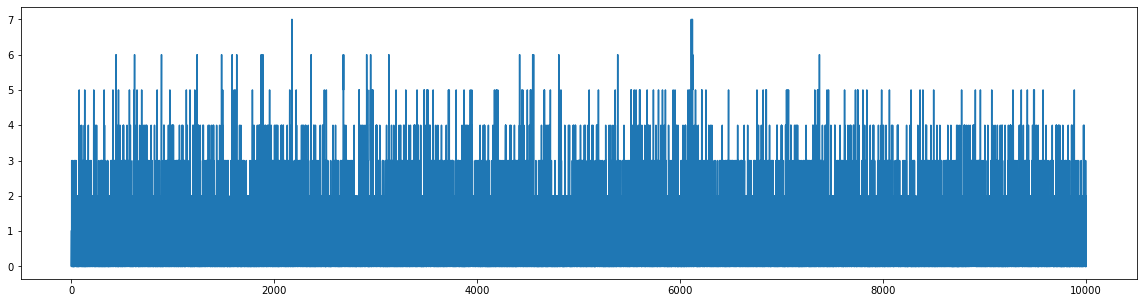

In [7]:
arrival_rate= 1
departure_rate = 1
servers = 7
end_time = 10000
res = simulate(arrival_rate, departure_rate, servers, end_time)
plt.figure(figsize=(20,5))
plt.plot([point['time'] for point in res], [point['active_servers'] for point in res])
probs = stationary_probabilities(res, servers)
for i in range(len(probs)):
    print(i, np.round(probs[i], 3))